# The goal of this notebook is to calculcate the impact of single terms (unigrams) on the polarity scores of sentences - publications - journals - publication sources 

A few different ways are used to approximate the influence of a single term

In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer, SentiText, VaderConstants
from nltk import tokenize

In [162]:
import pandas as pd
import numpy as np
import math

import re

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from tqdm import tqdm

### Import dataset

In [3]:
ALLEN_AI_SUBS_PATH = "../res/allenai/metadata_subset.csv"

df_allen = pd.read_csv(ALLEN_AI_SUBS_PATH)[['source_x', 'title', 'abstract', 'publish_time', 'journal', 'is_pr']]
df_allen = df_allen.fillna('')

print(len(df_allen.index))
df_allen.head(5)

58007


,source_x,title,abstract,publish_time,journal,is_pr
0,PMC,Sequence requirements for RNA strand transfer ...,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,The EMBO Journal,True
1,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,The EMBO Journal,True
2,PMC,Synthesis of a novel hepatitis C virus protein...,Hepatitis C virus (HCV) is an important human ...,2001-07-16,EMBO J,True
3,PMC,Structure of coronavirus main proteinase revea...,The key enzyme in coronavirus polyprotein proc...,2002-07-01,The EMBO Journal,True
4,PMC,Discontinuous and non-discontinuous subgenomic...,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,The EMBO Journal,True


In [4]:
raw_txt = df_allen[['title', 'abstract']].agg(' - '.join, axis=1)
raw_txt.values[:2]

array(['Sequence requirements for RNA strand transfer during nidovirus discontinuous subgenomic RNA synthesis - Nidovirus subgenomic mRNAs contain a leader sequence derived from the 5′ end of the genome fused to different sequences (‘bodies’) derived from the 3′ end. Their generation involves a unique mechanism of discontinuous subgenomic RNA synthesis that resembles copy-choice RNA recombination. During this process, the nascent RNA strand is transferred from one site in the template to another, during either plus or minus strand synthesis, to yield subgenomic RNA molecules. Central to this process are transcription-regulating sequences (TRSs), which are present at both template sites and ensure the fidelity of strand transfer. Here we present results of a comprehensive co-variation mutagenesis study of equine arteritis virus TRSs, demonstrating that discontinuous RNA synthesis depends not only on base pairing between sense leader TRS and antisense body TRS, but also on the primary se

## Variant A - Using just the values from the valence lexicon

This does not take into considerations closeness to degree adverbs (https://en.wiktionary.org/wiki/Category:English_degree_adverbs), Negations and other tweaks of the vader implementation  
Out-of-Vocabulary words are treated as neutral terms

In [5]:
sid = SentimentIntensityAnalyzer()
vader_constants = VaderConstants()
print("Top 10 positive terms")
print([(x, sid.lexicon[x]) for x in sorted(sid.lexicon, key=sid.lexicon.get, reverse=True)[:10]])
print("Top 10 negative terms")
print([(x, sid.lexicon[x]) for x in sorted(sid.lexicon, key=sid.lexicon.get)[:10]])

Top 10 positive terms
[('aml', 3.4), ('ilu', 3.4), ('ily', 3.4), ('magnificently', 3.4), ('lya', 3.3), ('ecstacy', 3.3), ('euphoria', 3.3), ('sweetheart', 3.3), ('143', 3.2), ('best', 3.2)]
Top 10 negative terms
[('rapist', -3.9), ('raping', -3.8), ('slavery', -3.8), ('fu', -3.7), ('kill', -3.7), ('murder', -3.7), ('rape', -3.7), ('terrorist', -3.7), ('hatefulness', -3.6), ('hell', -3.6)]


##### The top 10 positive words already indicate that Vader is more useful for domains like social media. A lot of abbreviations for 'i love you' are found at the top

#### Calculate per sentence polarity impact
Here I normalize the impact in a similar way to the Vader implementation (see https://www.nltk.org/api/nltk.sentiment.html#nltk.sentiment.vader.SentimentIntensityAnalyzer.score_valence). Punctuation amplifiers are taken into account on sentence level, so I do not include them on a term-base calculation.  
Note that the nltk Vader implementation adds the scalar 1 for positive terms and -1 for negative terms to account for the impact of neutral terms. e.g. the sentence `good or bad` is mapped first to lexicon values `[1.9, 0, -2.5]` and then translated to polarity impact scores `[2.9, 1, -3.5]`. The sum of absolute values (in this case `7.4`) is used for normalization.  
For neutral terms the polarity impact is fixed to `0`. This is a simplification for this calculation, removing a neutral term would increase the polarity impact of non-neutral terms in the actual implementation. For `good` the calculated impact is `2.9/7.4` for `bad` it is `-3.5/7.4`  
The polarity score of a term is multiplied by the number of it's occurences in the string

In [6]:
def clean_text(sentence):
    # this is done using the Vader implementation of nltk - it is a very simple nlp pre-processing function, which performs mainly punctuation removal
    sentitext = SentiText(sentence, vader_constants.PUNC_LIST, vader_constants.REGEX_REMOVE_PUNCTUATION)
    return [x.lower() for x in sentitext.words_and_emoticons]

def get_polarity_impact(term):
    valence = sid.lexicon.get(term) or 0
    return valence + 1 if valence >= 0 else valence -1 # neutral terms reduce impact of non-neutral terms

def get_sentence_polarity_impact_map(sentence):
    term_scores = dict()
    cleaned_sentence = clean_text(sentence)
    
    # aggregate term polarity impact per unique term
    for term in cleaned_sentence:
        if not term in term_scores:
            term_scores[term] = 0
        term_scores[term] += get_polarity_impact(term)
    
    total_impact_sum = sum([abs(x) for x in term_scores.values()])
    term_scores.update({term: term_impact/total_impact_sum if sid.lexicon.get(term) else 0 for term, term_impact in term_scores.items()})
    
    return {k:term_scores[k] for k in term_scores if term_scores[k] != 0}

For simple sentences this gives a good explanation of the polarity scores

In [89]:
get_sentence_polarity_impact_map("Well, this is bad")

{'well': 0.27631578947368424, 'bad': -0.46052631578947373}

In [87]:
sid.polarity_scores("Well, this is bad")

{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'compound': 0.4939}

Keep in mind: For more complex sentences (with negations, etc.) this does not work 

In [9]:
get_sentence_polarity_impact_map("Very well, but this is not better")

{'well': 0.21000000000000002, 'better': 0.29}

In [10]:
sid.polarity_scores("Very well, but this is not better")

{'neg': 0.317, 'neu': 0.51, 'pos': 0.173, 'compound': -0.3426}

### Calculate per document polarity impact
Here I chose to average individual impacts out over all sentences, i.e. sum up individual word impacts and divide by the number of sentences

In [11]:
def get_document_polarity_impact_map(doc):
    term_scores = dict()
    sentences = tokenize.sent_tokenize(doc)
    cnt_sentences = len(sentences)
    for sentence in sentences:
        sentence_term_map = get_sentence_polarity_impact_map(sentence)
        for term in sentence_term_map:
            term_scores[term] = term_scores.get(term, 0) + sentence_term_map[term]/cnt_sentences
    return term_scores        

In [12]:
get_document_polarity_impact_map("This sentence is used as an example for good and bad terms. The terms good and bad occur in both sentences")

{'sentence': 0.03892215568862275,
 'good': 0.19344399436421272,
 'bad': -0.23346688974991192,
 'sentences': 0.04411764705882353}

### Calculate per group polarity impact
Pretty similar to the document aggregation, here we average the impact over all documents within a group of documents

In [13]:
def get_group_polarity_impact_map(documents):
    term_scores = dict()
    cnt_docs = len(documents)
    for doc in tqdm(documents):
        doc_term_map = get_document_polarity_impact_map(doc)
        for term in doc_term_map:
            term_scores[term] = term_scores.get(term, 0) + doc_term_map[term]/cnt_docs
    return term_scores

In [14]:
get_group_polarity_impact_map(raw_txt[:5])

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 237.73it/s]


{'ensure': 0.0031476997578692495,
 'comprehensive': 0.0012987012987012987,
 'plays': 0.0031746031746031746,
 'strongly': 0.002843601895734597,
 'exploration': 0.0025435073627844713,
 'novel': 0.009068342337523674,
 'important': 0.004191804211724531,
 'mature': 0.0032258064516129024,
 'natural': 0.002197802197802198,
 'low': -0.0012773722627737226,
 'active': 0.0021774193548387095,
 'united': 0.0021705426356589145,
 'best': 0.003206106870229008,
 'lack': -0.0044660194174757275,
 'surprisingly': 0.0027160493827160497}

### Applying it to cord-19 sources

In [15]:
source_term_maps = dict()
sources = df_allen.source_x.unique()
for source in sources:
    print("Calculating for", source)
    docs = raw_txt[df_allen.source_x == source]
    source_term_maps[source] = get_group_polarity_impact_map(docs)

  0%|                                                                              | 21/32223 [00:00<02:34, 207.93it/s]

Calculating for PMC


  0%|▏                                                                             | 61/20898 [00:00<00:34, 597.92it/s]

Calculating for Elsevier


 58%|██████████████████████████████████████████████▍                                 | 58/100 [00:00<00:00, 574.18it/s]

Calculating for CZI


  7%|█████▋                                                                          | 65/918 [00:00<00:01, 643.59it/s]

Calculating for WHO


  3%|██▎                                                                            | 31/1064 [00:00<00:03, 295.24it/s]

Calculating for biorxiv


  2%|█▌                                                                             | 39/2007 [00:00<00:05, 389.94it/s]

Calculating for medrxiv


  9%|███████▌                                                                        | 75/797 [00:00<00:01, 370.75it/s]

Calculating for arxiv


100%|███████████████████████████████████████████████████████████████████████████████| 797/797 [00:02<00:00, 370.70it/s]


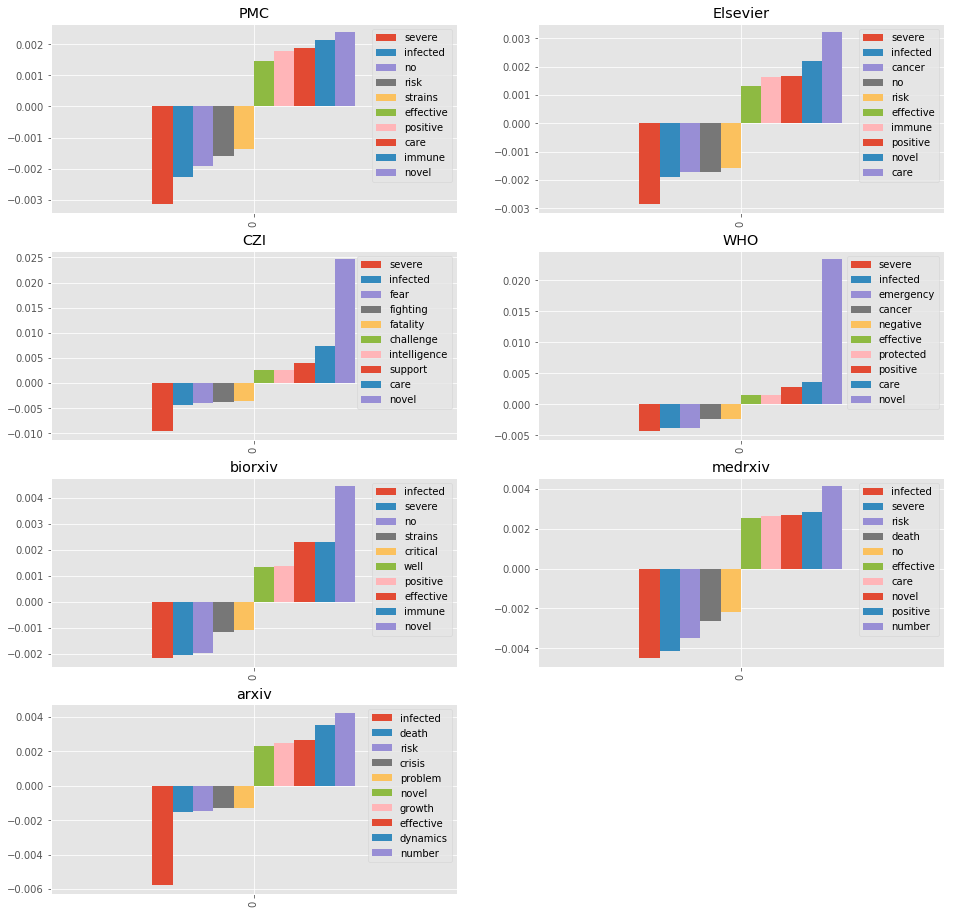

In [16]:
fig = plt.figure(figsize=(16,16))
for i, source in enumerate(sources):
    ax = fig.add_subplot(math.ceil(len(sources)/2),2,i+1)
    sorted_term_keys = sorted(source_term_maps[source], key=source_term_maps[source].get)
    top_term_map = {**{x:source_term_maps[source][x] for x in sorted_term_keys[:5]},**{x:source_term_maps[source][x] for x in sorted_term_keys[-5:]}}
    pd.DataFrame(top_term_map, index=[0]).plot(kind='bar', title=source, ax=ax)

In [54]:
def show_term_impact(term_lst):
    ts_map = dict()
    for source in sources:
        ts_map[source] = {term:source_term_maps[source].get(term,0) for term in term_lst}
    pd.DataFrame(ts_map).plot(kind='bar', title=f'Polarity impact of {term}', figsize=(4*min([len(term_lst),4]),4))

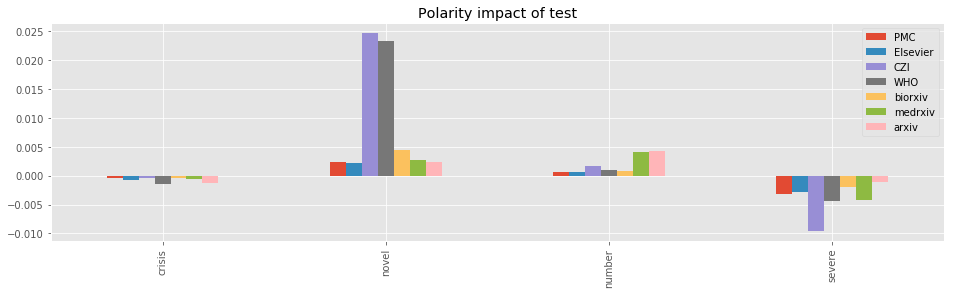

In [56]:
show_term_impact(['novel', 'number', 'severe', 'crisis'])

We see that `novel` seems to have a high polarity impact on `CZI` and `WHO`. For `arxiv` we still have no clear answer. Next the highest difference to average polarity are calculated

In [68]:
def get_polarity_diff_map(source):
    # calc polarity differences for all terms between one source and all others
    term_diff_map = dict()
    for term in source_term_maps[source].keys():
        cur_source_score = source_term_maps[source].get(term,0)
        avg_other_score = np.mean([source_term_maps[s].get(term,0) for s in sources if s != source])
        term_diff_map[term] = cur_source_score - avg_other_score
    return term_diff_map

In [75]:
arxiv_pol_difs = get_polarity_diff_map('arxiv')
sorted_keys = sorted(arxiv_pol_difs, key=arxiv_pol_difs.get)
print("Top 5 more positive terms", {k:arxiv_pol_difs[k] for k in reversed(sorted_keys[-5:])})
print("Top 5 more negative terms", {k:arxiv_pol_difs[k] for k in sorted_keys[:5]})

Top 5 more positive terms {'severe': 0.003324662055874345, 'number': 0.0027419295751415947, 'dynamics': 0.0024762147397097535, 'growth': 0.0017175804492611862, 'emergency': 0.0011316991729286}
Top 5 more negative terms {'novel': -0.007622153583107166, 'infected': -0.002591314849023037, 'care': -0.002480530164091537, 'problem': -0.0010459710559042156, 'immune': -0.0010120723001929212}


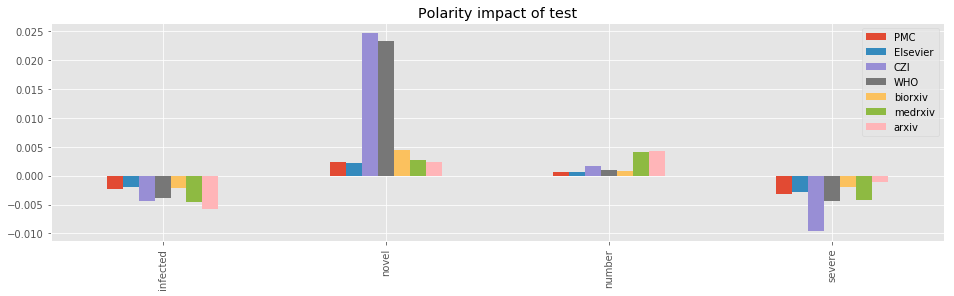

In [79]:
show_term_impact(['severe', 'number', 'novel', 'infected'])

## Variant B - Blackbox approach (term substitution)

As with the simple aproach from above the position is not taken into account, the second variant uses a blackbox approach similar to LIME (https://github.com/marcotcr/lime) in ML. In this case here we calculate the polarity impact of a term `t` as the difference of the calculated sentence-polarity `p(s)` and the polarity of a modified sentence `p(s')` (`p(s)-p(s')`). `s'` is the original sentence `s` but all occurences of `t` are replaced by a fixed out-of-vocabulary term `b`. The same term `b` is used for all sentences  
Susbtituting instead of removing words is very important as otherwise neutral terms would also affect polarity scores

In [124]:
substitute_term = 'ögibbon' # glibberish

def get_substitute_polarity(term, sentence):
    subst_sentence = re.sub(fr'\b{re.escape(term)}\b', substitute_term, sentence)
    return sid.polarity_scores(subst_sentence)['compound']

def get_sentence_polarity_impact_map(sentence):
    term_scores = dict()
    clean_tokens = clean_text(sentence)
    cleaned_sentence = " ".join(clean_tokens)
    sentence_polarity = sid.polarity_scores(cleaned_sentence)['compound']
    
    # calculate term polarity impact per unique term
    for term in set(clean_tokens):
        term_impact = sentence_polarity - get_substitute_polarity(term, cleaned_sentence)
        if term_impact != 0:
            term_scores[term] = term_impact
    
    return term_scores

In [125]:
get_sentence_polarity_impact_map("Well, this is bad")

{'bad': -0.6132, 'well': 0.20229999999999998}

In [127]:
sid.polarity_scores("Well, this is bad")

{'neg': 0.461, 'neu': 0.263, 'pos': 0.276, 'compound': -0.34}

Note that now the isolated polarity is no longer extracted. This approach calculates context-aware impact

In [128]:
get_sentence_polarity_impact_map("Very well, but this is not better")

{'very': 0.030799999999999994,
 'but': -0.3392,
 'well': 0.1356,
 'better': -0.5196000000000001,
 'not': -1.0179}

In [129]:
sid.polarity_scores("Very well, but this is not better")

{'neg': 0.317, 'neu': 0.51, 'pos': 0.173, 'compound': -0.3426}

Negations are now better detected. One has to keep in mind that this approach of analyzing unigrams still has flaws. e.g. `better` receives a negative score here as it is used in a negation. Using n-grams would attribute this negative polarity correctly to `not better`, but not to combinations like `lot better`

In [130]:
# Document and group-level calculations stay unchanged

In [131]:
get_group_polarity_impact_map(raw_txt[:5])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.95it/s]


{'ensure': 0.010908571428571427,
 'comprehensive': 0.0036571428571428575,
 'but': 0.0005457142857142839,
 'plays': 0.007142857142857143,
 'strongly': 0.007805714285714286,
 'exploration': 0.007543333333333334,
 'novel': 0.022193928571428573,
 'important': 0.00857457142857143,
 'mature': 0.012042857142857143,
 'natural': 0.01435142857142857,
 'extremely': -0.0016299999999999995,
 'low': -0.008459999999999999,
 'active': 0.007355000000000002,
 'united': 0.00843,
 'best': 0.012738,
 'lack': -0.006364,
 'surprisingly': 0.00592}

#### Applying in to CORD-19 sources (again)

In [132]:
source_term_maps = dict()
sources = df_allen.source_x.unique()
for source in sources:
    print("Calculating for", source)
    docs = raw_txt[df_allen.source_x == source]
    source_term_maps[source] = get_group_polarity_impact_map(docs)

  0%|                                                                                | 2/32223 [00:00<31:08, 17.24it/s]

Calculating for PMC


  0%|                                                                                        | 0/20898 [00:00<?, ?it/s]

Calculating for Elsevier


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Calculating for CZI


  0%|                                                                                          | 0/918 [00:00<?, ?it/s]

Calculating for WHO


  0%|                                                                                 | 1/1064 [00:00<01:55,  9.17it/s]

Calculating for biorxiv


  0%|                                                                                 | 2/2007 [00:00<02:21, 14.18it/s]

Calculating for medrxiv


  0%|                                                                                  | 1/797 [00:00<01:21,  9.71it/s]

Calculating for arxiv


100%|████████████████████████████████████████████████████████████████████████████████| 797/797 [00:59<00:00, 13.37it/s]


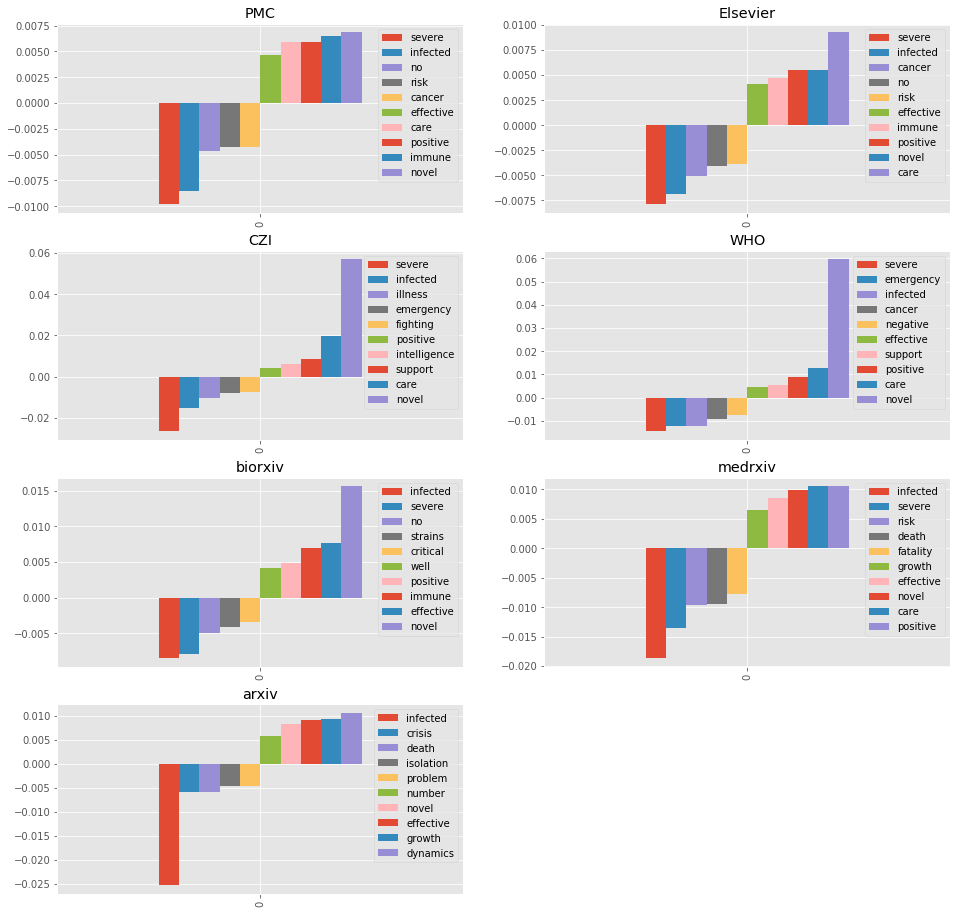

In [133]:
fig = plt.figure(figsize=(16,16))
for i, source in enumerate(sources):
    ax = fig.add_subplot(math.ceil(len(sources)/2),2,i+1)
    sorted_term_keys = sorted(source_term_maps[source], key=source_term_maps[source].get)
    top_term_map = {**{x:source_term_maps[source][x] for x in sorted_term_keys[:5]},**{x:source_term_maps[source][x] for x in sorted_term_keys[-5:]}}
    pd.DataFrame(top_term_map, index=[0]).plot(kind='bar', title=source, ax=ax)

In [145]:
for source in sources:
    print(source, np.sum(list(source_term_maps[source].values())))

PMC 0.027066566642764234
Elsevier 0.01851656098411339
CZI 0.026648621704684176
WHO 0.03245001211329053
biorxiv 0.07137289474399461
medrxiv 0.022359120851266377
arxiv 0.06761002863545211


In [149]:
for source in sources:
    print(source, 'pos', len([1 for x in source_term_maps[source].values() if x>0]), 'neg', len([1 for x in source_term_maps[source].values() if x<0]))

PMC pos 1111 neg 1217
Elsevier pos 974 neg 1075
CZI pos 140 neg 89
WHO pos 408 neg 384
biorxiv pos 472 neg 411
medrxiv pos 568 neg 561
arxiv pos 443 neg 400


In [150]:
for source in sources:
    print(source, 'pos', sum([x for x in source_term_maps[source].values() if x>0]), 'neg', sum([x for x in source_term_maps[source].values() if x<0]))

PMC pos 0.16341371516396735 neg -0.13634714852120267
Elsevier pos 0.14073594360398842 neg -0.1222193826198749
CZI pos 0.19068189141969152 neg -0.16403326971500726
WHO pos 0.2063560219798873 neg -0.1739060098665969
biorxiv pos 0.20130902872240386 neg -0.12993613397840936
medrxiv pos 0.19495922401607427 neg -0.17260010316480753
arxiv pos 0.224929817305934 neg -0.15731978867048182


In [152]:
arxiv_pol_difs = get_polarity_diff_map('arxiv')
sorted_keys = sorted(arxiv_pol_difs, key=arxiv_pol_difs.get)
print("Top 10 more positive terms", {k:arxiv_pol_difs[k] for k in reversed(sorted_keys[-10:])})
print("Top 10 more negative terms", {k:arxiv_pol_difs[k] for k in sorted_keys[:10]})

Top 10 more positive terms {'severe': 0.009924061753862687, 'dynamics': 0.008028289657758548, 'growth': 0.006651140197168339, 'number': 0.003749684357882182, 'effective': 0.003585234468430419, 'emergency': 0.003167881417213805, 'help': 0.0030774760067886152, 'cancer': 0.0030198971683308043, 'optimal': 0.002872424449189937, 'dynamic': 0.0027988760035054664}
Top 10 more negative terms {'novel': -0.01743588989204606, 'infected': -0.013546854276733205, 'care': -0.00731198535430572, 'crisis': -0.004056942639624508, 'problem': -0.0038560839832613436, 'immune': -0.0028886366668792155, 'positive': -0.002506765915948511, 'contagion': -0.0022139418240057504, 'death': -0.0019359186510710513, 'uncertainty': -0.001708574197383558}


In [153]:
arxiv_pol_difs = get_polarity_diff_map('biorxiv')
sorted_keys = sorted(arxiv_pol_difs, key=arxiv_pol_difs.get)
print("Top 10 more positive terms", {k:arxiv_pol_difs[k] for k in reversed(sorted_keys[-10:])})
print("Top 10 more negative terms", {k:arxiv_pol_difs[k] for k in sorted_keys[:10]})

Top 10 more positive terms {'infected': 0.006034854985995703, 'severe': 0.004763287032399685, 'immune': 0.004446041664504104, 'emergency': 0.0036495158420678086, 'risk': 0.0035604212939019564, 'illness': 0.002752377176774264, 'fatality': 0.0026312793222927006, 'death': 0.002568664247026837, 'approved': 0.0019106623120825942, 'effective': 0.0018836921017007088}
Top 10 more negative terms {'care': -0.009267648990005171, 'novel': -0.008888160423722116, 'strains': -0.0027599017986531197, 'united': -0.002272425289767387, 'inhibitors': -0.0020235142459659045, 'inhibit': -0.00178598986108747, 'positive': -0.0017850701315787918, 'support': -0.0017741930781620427, 'number': -0.0016897084112940195, 'stress': -0.0015867394416552052}


### Heatmap viz

In [181]:
impact_terms = set()
for source in sources:
    impact_terms |= set(sorted(source_term_maps[source], key= lambda x: abs(source_term_maps[source][x]))[-25:])
" - ".join(sorted(impact_terms))

'ability - active - approved - best - better - blame - cancer - care - confidence - crisis - critical - death - dynamic - dynamics - effective - efficient - emergency - failure - fatality - fear - fight - fighting - great - growth - help - illness - immune - importance - important - improved - increase - increased - infected - inhibition - inhibitors - injury - intelligence - isolated - isolation - low - lower - negative - no - novel - number - optimal - positive - problem - respectively - risk - severe - significant - strains - strong - suffering - support - suspected - threat - threats - united - useful - well'

In [192]:
def get_ana_df(impact_terms):
    ana_dict = dict()
    for source in sources:
        ana_dict[source] = {t:source_term_maps[source].get(t,0) for t in impact_terms}
    
    return pd.DataFrame(ana_dict)
df_ana = get_ana_df(impact_terms)
df_ana.head(5)

,PMC,Elsevier,CZI,WHO,biorxiv,medrxiv,arxiv
ability,0.001876,0.001164,0.000145,0.000920,0.002624,0.001171,0.000656
active,0.001913,0.001750,0.000000,0.001325,0.002388,0.001374,0.002382
approved,0.000531,0.000426,0.000317,0.000884,0.002572,0.000849,0.000962
best,0.001250,0.001159,0.000000,0.002330,0.001318,0.002240,0.003549
better,0.002082,0.001611,0.001431,0.001872,0.002291,0.001963,0.002899


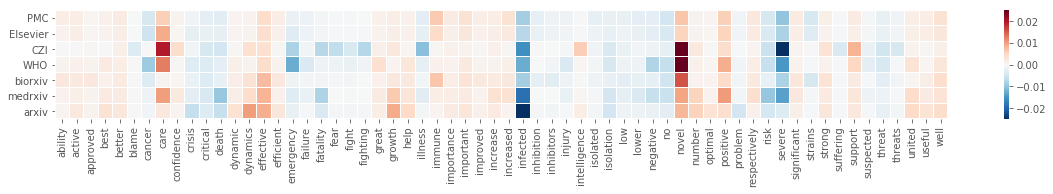

In [191]:
plt.figure(figsize = (20,2))
sns.heatmap(df_ana.T, linewidths=.1, cmap="RdBu_r", vmin=-0.025, vmax=0.025)

#### Top positive/negative terms

In [198]:
impact_terms = set()
for source in sources:
    impact_terms |= set(sorted(source_term_maps[source], key= lambda x: source_term_maps[source][x])[:40])
" - ".join(sorted(impact_terms))

"adverse - affected - argue - attack - avoid - ban - blame - block - burden - but - cancer - chaotic - combat - contagion - contagious - crisis - critical - damage - death - degradation - delay - detention - die - died - difficult - disaster - distress - emergency - error - errors - failure - fatal - fatalities - fatality - fear - fears - fight - fighting - flu - ill - illness - illnesses - infected - inhibit - inhibition - inhibitors - inhibitory - inhibits - injury - isolated - isolates - isolation - killed - lack - limited - loss - low - lower - negative - nervous - no - not - poor - pressure - problem - problems - restriction - risk - risks - severe - severely - strains - stress - suffering - suspected - threat - threats - trauma - tumor - uncertainty - underestimate - virulent - vulnerable - weren't"

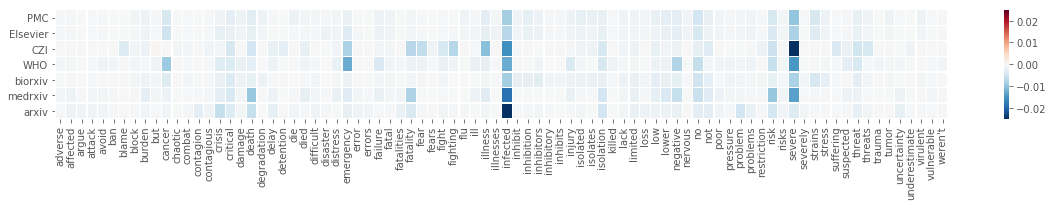

In [199]:
df_neg_terms = get_ana_df(impact_terms)
plt.figure(figsize = (20,2))
sns.heatmap(df_neg_terms.T, linewidths=.1, cmap="RdBu_r", vmin=-0.025, vmax=0.025)

In [202]:
impact_terms = set()
for source in sources:
    impact_terms |= set(sorted(source_term_maps[source], key= lambda x: source_term_maps[source][x])[-40:])
" - ".join(sorted(impact_terms))

'ability - active - approved - benefits - best - better - care - caring - challenge - comprehensive - confidence - definitely - determined - dynamic - dynamics - effective - effectively - efficiency - efficient - efficiently - ensure - excellent - exuberant - fit - free - freedom - good - great - greater - growth - hand - healthy - help - highlight - hope - immune - importance - important - importantly - improve - improved - improvement - increase - increased - intelligence - interest - like - natural - novel - number - optimal - original - play - positive - powerful - progress - promising - protect - protected - recommend - respectively - responsible - robust - safe - safety - security - share - sharing - significant - solution - special - strengthening - strong - success - successful - successfully - support - treat - true - united - useful - value - values - well'

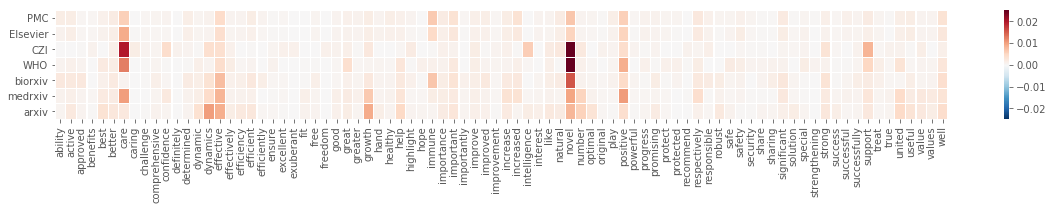

In [203]:
df_pos_terms = get_ana_df(impact_terms)
plt.figure(figsize = (20,2))
sns.heatmap(df_pos_terms.T, linewidths=.1, cmap="RdBu_r", vmin=-0.025, vmax=0.025)

#### Top 50 positive arxiv terms

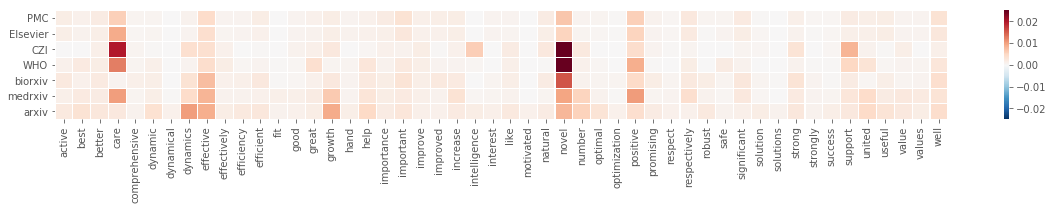

In [193]:
impact_terms = sorted(source_term_maps['arxiv'], key= lambda x: (source_term_maps['arxiv'][x]))[-50:]
df_arx_terms = get_ana_df(impact_terms)
plt.figure(figsize = (20,2))
sns.heatmap(df_arx_terms.T, linewidths=.1, cmap="RdBu_r", vmin=-0.025, vmax=0.025)